<a href="https://colab.research.google.com/github/Vinni22Z/Delivery-Insight-ML/blob/main/notebook_entrega.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Análise dos Fatores que Influenciam a Entrega Correta de Pedidos

Este projeto busca prever a entrega correta dos pedidos e entender os principais fatores envolvidos nesse processo, utilizando respostas de uma pesquisa de satisfação de clientes no Kashmir Cafe. Muitas empresas enfrentam problemas com erros de pedidos e insatisfação dos clientes, muitas vezes sem compreender totalmente as causas desses desafios. Com o uso de técnicas de Machine Learning, é possível antecipar problemas associados à entrega incorreta, agir proativamente para aprimorar a experiência do cliente e reduzir prejuízos.

O objetivo do trabalho é comparar o desempenho de diferentes modelos e abordagens para prever a precisão dos pedidos:

* KNN e RandomForest

* Com e sem Engenharia de Recursos

* Com e sem balanceamento de dados (SMOTE e RandomUnderSampler)

# Importação de Bibliotecas

In [152]:
# Importação das bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Modelagem e avaliação
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler

# Técnicas de reamostragem e pipeline do imbalanced-learn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline as ImbPipeline




Nesta etapa, são importadas as bibliotecas essenciais para análise, visualização e modelagem.
As bibliotecas `pandas` e `numpy` são usadas para manipulação de dados, enquanto `matplotlib` e `seaborn` apoiam a análise visual.
Na parte de Machine Learning, utilizamos `scikit-learn` e `imbalanced-learn` para construção dos modelos, pipelines e técnicas de balanceamento.
O uso de `RandomForestClassifier` e `KNeighborsClassifier` permite observar o contraste entre um modelo baseado em distância e outro baseado em árvores de decisão.

# Leitura e Inspeção dos Dados
* Após importar o dataset, a primeira etapa é inspecionar sua estrutura para compreender a natureza das variáveis.
Isso envolve verificar colunas, tipos de dados e possíveis inconsistências.
Aqui também são feitos ajustes de nomenclatura para tornar os nomes mais claros e padronizados — essencial para manter o código legível e profissional.

In [153]:
# inspeção inicial dos dados
dif = pd.read_csv('Customer-survey-data.csv')
dif

,Customer,How satisfied were you with your overall delivery experience at Ali? 1-5 where 1 = extremely dissatisfied and 5 = extremely satisfied,How satisfied were you with the quality of the food at Alis? 1-5 where 1 = extremely dissatisfied and 5 = extremely satisfied,How satisfied were you with the speed of delivery at Alis? 1-5 where 1 = extremely dissatisfied and 5 = extremely satisfied,Was your order accurate? Please respond yes or no.
0,1,5.0,3.0,4.0,Yes
1,2,3.0,4.0,3.0,Yes
2,3,4.0,5.0,2.0,Yes
3,4,5.0,3.0,4.0,Yes
4,5,2.0,5.0,1.0,Yes
...,...,...,...,...,...
10611,10612,4.0,2.0,3.0,Yes
10612,10613,3.0,3.0,3.0,Yes
10613,10614,5.0,3.0,3.0,Yes
10614,10615,3.0,3.0,3.0,Yes


In [154]:
## Renomeia colunas para nomes mais descritivos e padronizados
dif.columns = ['Id_Cliente','Exp_Entrega','Qual_Alimento','Tempo','Precisao_ped']

In [155]:
## Verifica estrutura
dif.tail()

,Id_Cliente,Exp_Entrega,Qual_Alimento,Tempo,Precisao_ped
10611,10612,4.0,2.0,3.0,Yes
10612,10613,3.0,3.0,3.0,Yes
10613,10614,5.0,3.0,3.0,Yes
10614,10615,3.0,3.0,3.0,Yes
10615,10616,1.0,3.0,3.0,Yes


In [156]:
# dimensões
dif.shape

(10616, 5)

In [157]:
# Estatísticas descritivas das variáveis numéricas
dif[['Exp_Entrega','Qual_Alimento','Tempo']].describe()

,Exp_Entrega,Qual_Alimento,Tempo
count,10198.000000,10364.000000,10377.000000
mean,3.325260,3.332015,3.322926
std,1.419754,1.414709,1.408918
min,1.000000,1.000000,1.000000
25%,2.000000,2.000000,2.000000
50%,3.000000,3.000000,3.000000
75%,5.000000,5.000000,5.000000
max,5.000000,5.000000,5.000000


In [158]:
# Verifica valores ausentes
dif.isna().sum()

,0
Id_Cliente,0
Exp_Entrega,418
Qual_Alimento,252
Tempo,239
Precisao_ped,660


In [159]:
# Verifica valores duplicados
dif.duplicated().sum()

np.int64(0)

In [160]:
# Percentual de valores ausentes por coluna
dif.isna().sum() / len(dif) * 100

,0
Id_Cliente,0.000000
Exp_Entrega,3.937453
Qual_Alimento,2.373775
Tempo,2.251319
Precisao_ped,6.217031


#Tratamento de dados ausentes

Como o percentual de valores ausentes era inferior a 7% em todas as colunas, optei por remover essas amostras para manter a integridade dos dados e evitar distorções no cálculo das distâncias do modelo KNN

In [161]:
dif = dif.dropna()

In [162]:
dif.isna().sum()


,0
Id_Cliente,0
Exp_Entrega,0
Qual_Alimento,0
Tempo,0
Precisao_ped,0


como vemos , agora nao a valores nulos , vamos prosseguir


In [163]:
# Confirma o tipo de dados e não existência de nulos
dif.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9297 entries, 0 to 10615
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id_Cliente     9297 non-null   int64  
 1   Exp_Entrega    9297 non-null   float64
 2   Qual_Alimento  9297 non-null   float64
 3   Tempo          9297 non-null   float64
 4   Precisao_ped   9297 non-null   object 
dtypes: float64(3), int64(1), object(1)
memory usage: 435.8+ KB


In [164]:
# Verifica possíveis combinações únicas de variáveis
dif[['Exp_Entrega', 'Qual_Alimento','Tempo','Precisao_ped']].drop_duplicates()

,Exp_Entrega,Qual_Alimento,Tempo,Precisao_ped
0,5.0,3.0,4.0,Yes
1,3.0,4.0,3.0,Yes
2,4.0,5.0,2.0,Yes
4,2.0,5.0,1.0,Yes
5,5.0,2.0,5.0,Yes
...,...,...,...,...
7474,4.0,4.0,3.0,No
7519,3.0,4.0,5.0,No
8336,5.0,2.0,3.0,No
9204,5.0,2.0,5.0,No


In [165]:
# Converte variável alvo "Satisfação" para formato numérico binário
dif['Precisao_ped'] = dif['Precisao_ped'].replace({'No':0,'Yes': 1})

/tmp/ipython-input-66145971.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dif['Precisao_ped'] = dif['Precisao_ped'].replace({'No':0,'Yes': 1})
/tmp/ipython-input-66145971.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dif['Precisao_ped'] = dif['Precisao_ped'].replace({'No':0,'Yes': 1})


In [166]:
# Visualiza primeiras linhas pós-transformação
dif.head()

,Id_Cliente,Exp_Entrega,Qual_Alimento,Tempo,Precisao_ped
0,1,5.0,3.0,4.0,1
1,2,3.0,4.0,3.0,1
2,3,4.0,5.0,2.0,1
3,4,5.0,3.0,4.0,1
4,5,2.0,5.0,1.0,1


In [167]:
df = dif.copy()

#Análise exploratória básica

Nesta fase, o foco é entender o comportamento das variáveis e suas relações com a satisfação do cliente.
Alguns pontos importantes incluem:

* Frequência de respostas em cada nível de satisfação (1 a 5);

* Identificação de padrões ou tendências entre “Tempo de entrega”, “Experiência” e “Qualidade do alimento”;

* Detecção de valores ausentes ou anômalos.

Gráficos de barras e heatmaps ajudam a visualizar a correlação entre variáveis, o que apoia decisões futuras sobre Feature Engineering e escolha de modelos.

In [168]:
# Valores únicos e suas contagens em cada coluna
colunas= ['Exp_Entrega', 'Qual_Alimento','Tempo','Precisao_ped']
valores_unicos = {}
for coluna in colunas:
  valores_unicos[coluna] = dif[coluna].unique()
print(valores_unicos)

{'Exp_Entrega': array([5., 3., 4., 2., 1.]), 'Qual_Alimento': array([3., 4., 5., 2., 1.]), 'Tempo': array([4., 3., 2., 1., 5.]), 'Precisao_ped': array([1, 0])}


In [169]:
contagem = {}
for coluna in colunas:
  contagem[coluna] = dif[coluna].value_counts()

print(contagem)


{'Exp_Entrega': Exp_Entrega
5.0    3026
3.0    2094
2.0    1860
1.0    1173
4.0    1144
Name: count, dtype: int64, 'Qual_Alimento': Qual_Alimento
5.0    3004
3.0    2099
2.0    1835
4.0    1220
1.0    1139
Name: count, dtype: int64, 'Tempo': Tempo
5.0    2918
3.0    2098
2.0    1845
4.0    1294
1.0    1142
Name: count, dtype: int64, 'Precisao_ped': Precisao_ped
1    6647
0    2650
Name: count, dtype: int64}


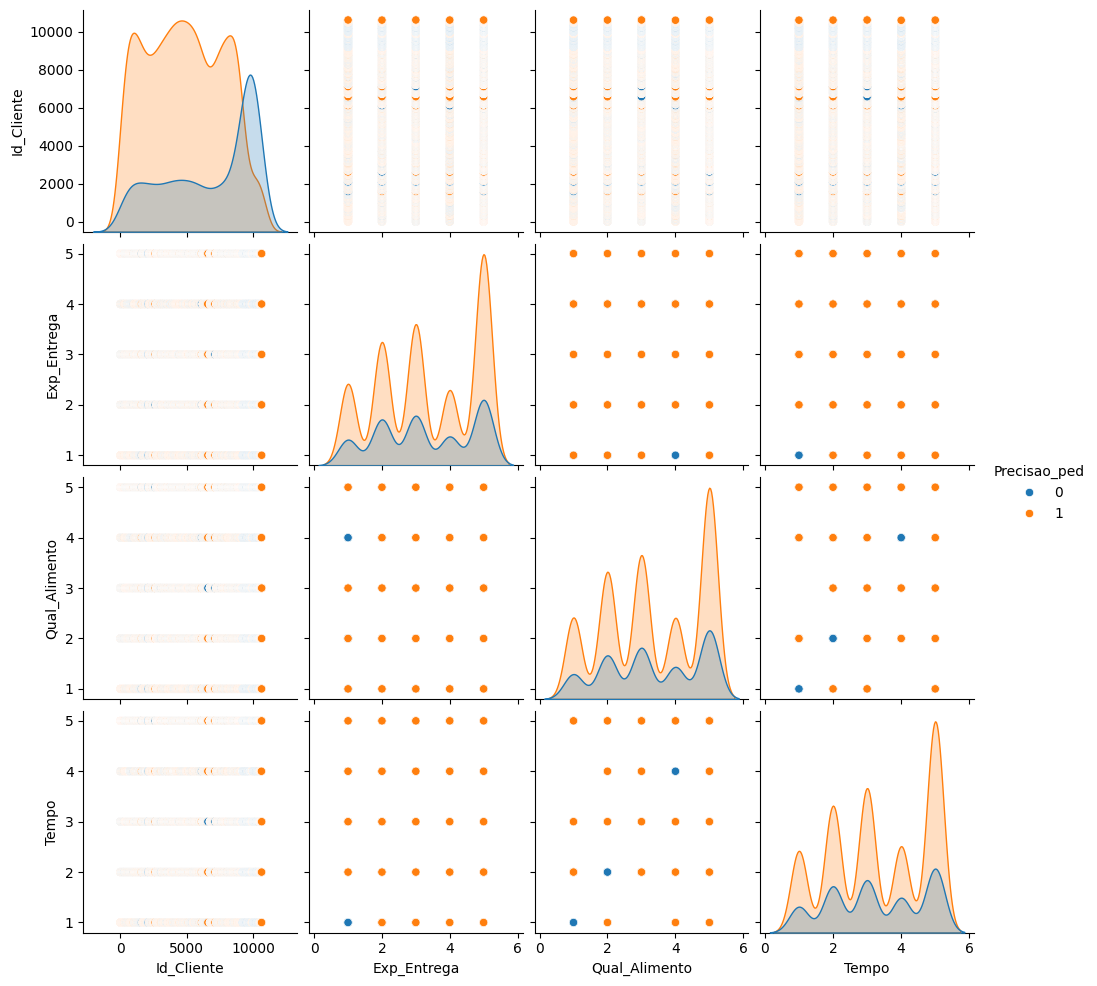

In [170]:
# Gráfico de dispersão entre as variáveis (colorido pela satisfação)
sns.pairplot(dif, hue='Precisao_ped')

* Como visto no pairplot, as features de avaliação (Qualidade do Alimento, Tempo, etc.) são notas de 1 a 5, criando um gráfico em 'grade'

<Axes: xlabel='Precisao_ped', ylabel='count'>

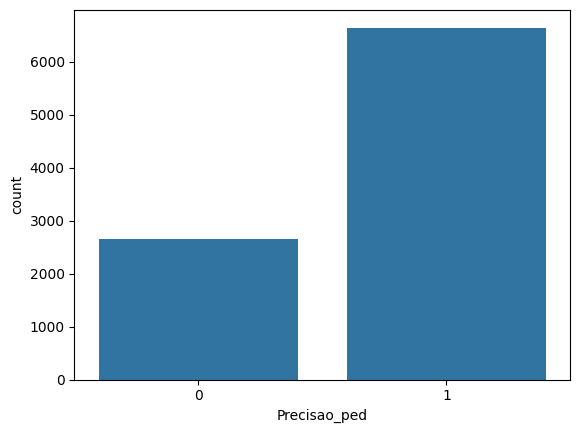

In [171]:
# Distribuição da variável alvo
sns.countplot(x='Precisao_ped', data = dif)

*  O countplot mostrou que temos muito mais clientes satisfeitos (Classe 1) do que insatisfeitos (Classe 0). Isso é um problema sério: um modelo 'preguiçoso' poderia simplesmente chutar '1' para tudo e ter uma acurácia alta, mas seria inútil.

*  Por causa desse desbalanceamento, a Acurácia não é uma boa métrica. Vamos focar no F1-Score (macro), que avalia o desempenho em ambas as classes de forma justa."

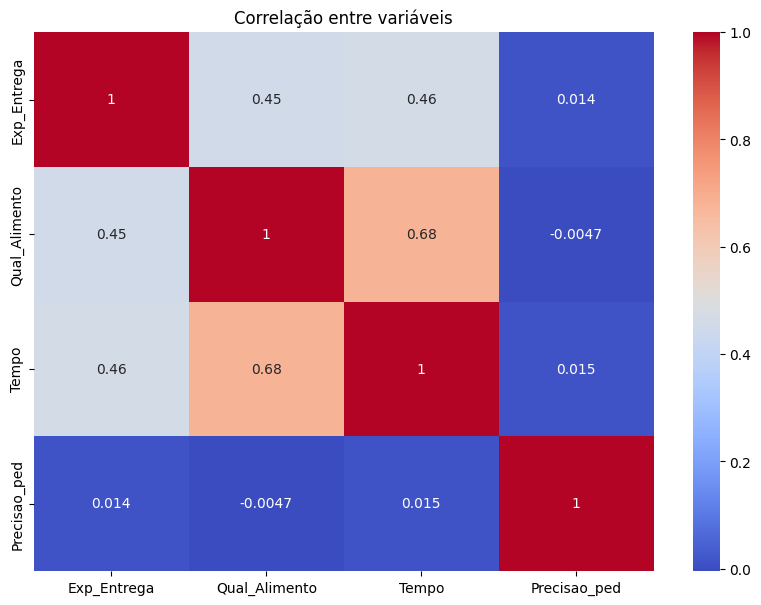

In [172]:
# Mapa de calor de correlação entre variáveis
plt.figure(figsize=(10,7))
sns.heatmap(dif[['Exp_Entrega','Qual_Alimento','Tempo','Precisao_ped']]
            .corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Correlação entre variáveis')
plt.show()

* O conjunto mostra uma forte coerência interna entre tempo, entrega e qualidade, mas a satisfação parece independente dessas três dimensões.

#  Feature Engineering

Nesta etapa, são testadas abordagens apenas com as variáveis ordinais (notas de 1 a 5) mantidas como números inteiros, o que preserva a ordem natural e favorece modelos como o KNN.

Além disso, foram criadas novas variáveis a partir das existentes, com o objetivo de comparar como essas transformações afetam o desempenho e as métricas dos modelos.

In [173]:
dif = pd.get_dummies(df,columns=['Exp_Entrega',	'Qual_Alimento',	'Tempo'])
dif = dif.astype(int)

In [174]:
dif.head()

,Id_Cliente,Precisao_ped,Exp_Entrega_1.0,Exp_Entrega_2.0,Exp_Entrega_3.0,Exp_Entrega_4.0,Exp_Entrega_5.0,Qual_Alimento_1.0,Qual_Alimento_2.0,Qual_Alimento_3.0,Qual_Alimento_4.0,Qual_Alimento_5.0,Tempo_1.0,Tempo_2.0,Tempo_3.0,Tempo_4.0,Tempo_5.0
0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0
1,2,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0
2,3,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0
3,4,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0
4,5,1,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0


#Separação em features e alvo

In [175]:
# dataset original
X_original = df.drop(columns=['Precisao_ped','Id_Cliente'])
y_original = df['Precisao_ped']

# dataset com Feature Engineering
X_fe = dif.drop(columns=['Precisao_ped','Id_Cliente'])
y_fe = dif['Precisao_ped']


In [176]:
# Divide em treino e teste mantendo a proporção das classes
# O parâmetro stratify=y garante que a proporção das classes (0 e 1)
# seja mantida em ambas as amostras, evitando desequilíbrio entre elas.

# sem Feature Engineering
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X_original, y_original, test_size=0.2, random_state=42)


# com Feature Engineering
X_train_fe, X_test_fe, y_train_fe, y_test_fe = train_test_split(X_fe, y_fe, test_size=0.2, random_state=42)

In [177]:
# Após a divisão, é verificada a proporção das classes
print(y_train_orig.value_counts(normalize=True))
print(y_test_orig.value_counts(normalize=True))

Precisao_ped
1    0.71588
0    0.28412
Name: proportion, dtype: float64
Precisao_ped
1    0.71129
0    0.28871
Name: proportion, dtype: float64


# Modelagem: KNN e RandomForest

Nesta seção, o projeto testa e compara dois modelos:

* KNN (K-Nearest Neighbors):
Baseia-se na proximidade entre amostras; sua performance depende fortemente da escala e do balanceamento dos dados.
Ideal para problemas com variáveis numéricas ordinais e padrões locais.

* RandomForest:
Um modelo mais robusto, baseado em múltiplas árvores de decisão.
Tende a lidar melhor com dados ruidosos e pode capturar relações não lineares.
Além disso, fornece importância das variáveis, ajudando a entender quais fatores mais influenciam a satisfação.

Ambos os modelos passam por uma busca de hiperparâmetros (GridSearchCV), garantindo uma comparação justa.

In [178]:
#A função (roda_pipeline) automatiza o processo de treino, previsão e avaliação de um modelo de aprendizado de máquina. Ela recebe o modelo, os dados de treino e teste, e:
     #Treina o modelo com os dados de treino
     #Faz análise usando os dados de teste
     #Calcular a acurácia e imprimir um relatório detalhado das métricas
     #Retorna a acurácia para comparação entre modelos
#Assim, é fácil testar diferentes modelos e comparar o desempenho de forma simples e organizada sem precisar repetir o codigo quando for testar com dados que foram feitos a Feature Engineering.

def roda_pipeline(modelo, X_train, X_test, y_train, y_test, nome=None):
    # Treina o modelo
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)

    # Relatório de classificação em formato texto e dicionário
    report_str = classification_report(y_test, y_pred, zero_division=0)
    report_dict = classification_report(y_test, y_pred, zero_division=0, output_dict=True)

    # Extrai os recalls das classes 0 e 1
    recall_classe_0 = report_dict.get('0', {}).get('recall', 0.0)
    recall_classe_1 = report_dict.get('1', {}).get('recall', 0.0)

    # Impressão dos resultados
    print(f'{"-"*45}\nResultados - {nome if nome else type(modelo).__name__}')
    print(report_str)
    print(f"Recall Classe 0 (Insatisfeito): {recall_classe_0:.4f}")
    print(f"Recall Classe 1 (Satisfeito):   {recall_classe_1:.4f}")

    # Retorna ambos os valores
    return recall_classe_0, recall_classe_1

#MODELO 0 — KNN (BASELINE)

In [179]:
# pipeline simples, apenas com scaler e o KNN
pipe0 = Pipeline([
    ('scaler', MinMaxScaler()),          # Normaliza as variáveis
    ('knn', KNeighborsClassifier())])    # Classificador KNN

In [180]:
pipe0.fit(X_train_orig, y_train_orig)

Pipeline(steps=[('scaler', MinMaxScaler()), ('knn', KNeighborsClassifier())])

In [181]:
  y_pred_baseline = pipe0.predict(X_test_orig)

In [182]:
print(classification_report(y_test_orig, y_pred_baseline,zero_division=0))
print(accuracy_score(y_test_orig, y_pred_baseline))

              precision    recall  f1-score   support

           0       0.24      0.07      0.11       537
           1       0.71      0.91      0.79      1323

    accuracy                           0.67      1860
   macro avg       0.47      0.49      0.45      1860
weighted avg       0.57      0.67      0.60      1860

0.6650537634408602


* O modelo Baseline foi construído apenas com a padronização dos dados (StandardScaler) e o KNN padrão, sem qualquer técnica de balanceamento. Ele serve como ponto de referência para comparar o impacto das estratégias de reamostragem aplicadas posteriormente.

* Apesar da acurácia elevada, o modelo falha no objetivo de negócio: identificar corretamente os clientes insatisfeitos.
Na prática, isso significa que o sistema teria baixo valor preditivo para detectar possíveis problemas ou insatisfações — justamente o tipo de insight mais relevante.
Ou seja, a alta acurácia é ilusória: o modelo parece bom, mas não entrega utilidade real.

#  MODELO 1 — KNN com Undersampling

In [183]:
pipe1 = ImbPipeline([
    ('UnderSampler',RandomUnderSampler(random_state=10 ,sampling_strategy=0.4)),     # Subamostragem da classe majoritária, ajustado com sampling_strategy de 0.4
    ('scaler', MinMaxScaler()),                                                      # Normaliza as variáveis
    ('knn', KNeighborsClassifier())                                                  # Classificador KNN

])

In [184]:
# Treina o pipeline 1
pipe1.fit(X_train_orig, y_train_orig)

Pipeline(steps=[('UnderSampler',
                 RandomUnderSampler(random_state=10, sampling_strategy=0.4)),
                ('scaler', MinMaxScaler()), ('knn', KNeighborsClassifier())])

In [185]:
# Faz previsões
y_pred_under = pipe1.predict(X_test_orig)

# Relatórios e métricas
print(classification_report(y_test_orig, y_pred_under,zero_division=0))
print(accuracy_score(y_test_orig, y_pred_under))

              precision    recall  f1-score   support

           0       0.29      0.91      0.44       537
           1       0.75      0.11      0.19      1323

    accuracy                           0.34      1860
   macro avg       0.52      0.51      0.32      1860
weighted avg       0.62      0.34      0.26      1860

0.33978494623655914


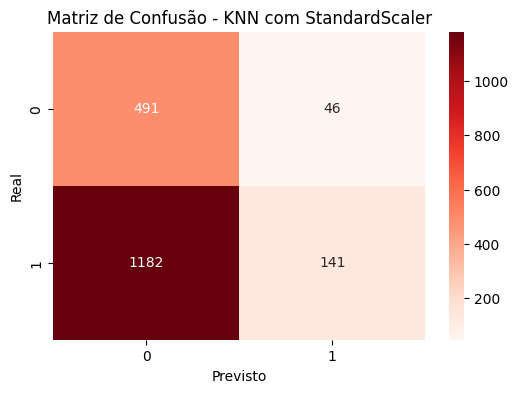

In [186]:
# Matriz de confusão MODEL1
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test_orig, y_pred_under), annot=True, fmt='d', cmap= 'Reds')
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de Confusão - KNN com StandardScaler')
plt.show()

In [187]:
# Validação cruzada para verificar estabilidade do modelo
scoress = cross_val_score(pipe1, X_original, y_original, cv=5, scoring='accuracy')
print(f'Acurácias por fold: {scoress}')
print(f'Média da acurácia: {scoress.mean():.4f}')

Acurácias por fold: [0.30376344 0.30322581 0.29747176 0.32167832 0.36740183]
Média da acurácia: 0.3187


* A técnica de Undersampling reduziu demais o volume da classe majoritária, o que fez o KNN perder a noção real da distribuição de dados.
Como o KNN depende fortemente da densidade e dos vizinhos, a remoção excessiva de amostras distorceu o espaço de decisão, resultando em uma acurácia e F1-score muito inferiores.
Apesar de ter elevado o recall da classe minoritária, o custo foi alto: o modelo passou a classificar quase tudo como "insatisfeito".

#MODELO 2 — KNN com SMOTE (oversampling)

In [188]:
pipe2 = ImbPipeline([
     ('smote', SMOTE(random_state=10)),      #Técnica de Superamostragem Sintética de Minorias('knn', KNeighborsClassifier())
     ('max_scaler', MinMaxScaler()),          # Normaliza as variáveis
     ('knn', KNeighborsClassifier())         # Classificador KNN
])

In [189]:
# Treina o pipeline 2
pipe2.fit(X_train_orig, y_train_orig)

Pipeline(steps=[('smote', SMOTE(random_state=10)),
                ('max_scaler', MinMaxScaler()),
                ('knn', KNeighborsClassifier())])

In [190]:
# Faz previsões
y_pred = pipe2.predict(X_test_orig)


# Relatórios e métricas
print(classification_report(y_test_orig, y_pred,zero_division=0))
print(accuracy_score(y_test_orig, y_pred))

              precision    recall  f1-score   support

           0       0.25      0.05      0.08       537
           1       0.71      0.94      0.81      1323

    accuracy                           0.68      1860
   macro avg       0.48      0.50      0.44      1860
weighted avg       0.58      0.68      0.60      1860

0.6849462365591398


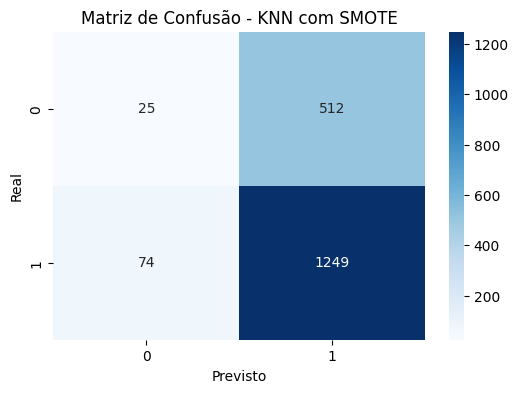

In [191]:
# Relatórios e métricas MODEL2
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test_orig, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de Confusão - KNN com SMOTE')
plt.show()

In [192]:
# Validação cruzada para verificar estabilidade do modelo
scores = cross_val_score(pipe2, X_original, y_original, cv=5, scoring='accuracy')
print(f'Acurácias por fold: {scores}')
print(f'Média da acurácia: {scores.mean():.4f}')

Acurácias por fold: [0.70752688 0.63709677 0.56428187 0.68316299 0.62990855]
Média da acurácia: 0.6444


* Nesta versão, foi aplicada a técnica de SMOTE (Synthetic Minority Over-sampling Technique), responsável por gerar novas amostras sintéticas da classe minoritária com base na interpolação dos vizinhos mais próximos.
O objetivo é equilibrar a quantidade de exemplos entre as classes sem simplesmente duplicar instâncias, preservando a variabilidade dos dados.

* A aplicação do SMOTE, com os parâmetros atuais, falhou em resolver o problema de desbalanceamento. O modelo continua com o mesmo vício de prever apenas a classe majoritária.

#MODELO 3 — KNN com SMOTEENN (combinação oversampling + undersampling)

In [193]:
pipe3 = ImbPipeline([
        ('smoteenn', SMOTEENN(random_state=10)),       # Híbrido de oversampling (SMOTE) e limpeza (ENN).
        ('scaler', MinMaxScaler()),                    # Normaliza as variáveis
        ('knn', KNeighborsClassifier())                # Classificador KNN

])

In [194]:
# Faz previsões
pipe3.fit(X_train_orig, y_train_orig)


Pipeline(steps=[('smoteenn', SMOTEENN(random_state=10)),
                ('scaler', MinMaxScaler()), ('knn', KNeighborsClassifier())])

In [195]:
y_pred_smoteenn = pipe3.predict(X_test_orig)

In [196]:
# Relatórios e métricas
print(confusion_matrix(y_test_orig, y_pred_smoteenn))
print(classification_report(y_test_orig, y_pred_smoteenn,zero_division=0))
print("F1-score (macro):", f1_score(y_test_orig, y_pred_smoteenn, average='macro'))

[[   0  537]
 [   0 1323]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       537
           1       0.71      1.00      0.83      1323

    accuracy                           0.71      1860
   macro avg       0.36      0.50      0.42      1860
weighted avg       0.51      0.71      0.59      1860

F1-score (macro): 0.41564561734213007


In [197]:
# Validação cruzada para verificar estabilidade do modelo
score = cross_val_score(pipe3, X_original, y_original, cv=5, scoring='accuracy')
print(f'Acurácias por fold: {score}')
print(f'Média da acurácia: {score.mean():.4f}')

Acurácias por fold: [0.71344086 0.70913978 0.69284562 0.69876278 0.66433566]
Média da acurácia: 0.6957


* Este modelo usa uma técnica híbrida, SMOTEENN, que primeiro aplica o SMOTE (oversampling) e depois o ENN (Edited Nearest Neighbours) para limpar o dataset, removendo ruídos e amostras sobrepostas.

* A técnica SMOTEENN foi contraproducente. A limpeza do ENN pode ter removido instâncias importantes da Classe 0, tornando-a ainda mais difícil de ser detectada. Este modelo é o pior dos três em termos de detecção da minoria.

#  GRID SEARCH — Otimização dos hiperparâmetros do KNN

In [198]:
# Define o espaço de busca para o GridSearchCV
list_grid = {
    'knn__n_neighbors': [3,5,7,9,11,15,21],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan'],
}



In [199]:
# Executa busca em grade com validação cruzada (5 folds)
grid_knn = GridSearchCV(
    pipe2 ,
    list_grid ,
    cv=5 ,
    scoring= 'f1_macro',
    n_jobs=-1)

In [200]:
# Treina o modelo com os melhores hiperparâmetros
grid_knn.fit(X_train_orig, y_train_orig)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=10)),
                                       ('max_scaler', MinMaxScaler()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'knn__metric': ['euclidean', 'manhattan'],
                         'knn__n_neighbors': [3, 5, 7, 9, 11, 15, 21],
                         'knn__weights': ['uniform', 'distance']},
             scoring='f1_macro')

In [201]:
print('o melhor parametro :', grid_knn.best_params_)
print('melhor f1_score :' ,grid_knn.best_score_)


o melhor parametro : {'knn__metric': 'euclidean', 'knn__n_neighbors': 3, 'knn__weights': 'uniform'}
melhor f1_score : 0.4797259642097201


In [202]:
# Avalia o modelo otimizado no conjunto de teste
cv_model = grid_knn.best_estimator_
y__pred = cv_model.predict(X_test_orig)

print(classification_report(y_test_orig, y__pred,zero_division=0))
print("F1-score (macro):", f1_score(y_test_orig, y__pred, average='macro'))

              precision    recall  f1-score   support

           0       0.27      0.28      0.28       537
           1       0.70      0.69      0.70      1323

    accuracy                           0.57      1860
   macro avg       0.49      0.49      0.49      1860
weighted avg       0.58      0.57      0.58      1860

F1-score (macro): 0.4883145140113291


In [203]:
scor = cross_val_score(grid_knn.best_estimator_, X_original, y_original, cv=5, scoring='accuracy')
print(f'Acurácias por fold: {scor}')
print(f'Média da acurácia: {scor.mean():.4f}')

Acurácias por fold: [0.70913978 0.65591398 0.59279182 0.66325982 0.62937063]
Média da acurácia: 0.6501


* Esses números evidenciam que o modelo otimizado pelo Grid Search ficou mais equilibrado entre as classes do que o baseline, porém ainda enfrenta dificuldades para prever corretamente a classe minoritária. embora o modelo tenha boa performance para a maioria dos clientes (classe 1), ainda precisa melhorar para ser útil na detecção dos clientes insatisfeitos (classe 0).

* # Random Forest Classifier


In [204]:
# Treinamento inicial do Random Forest
rf = Pipeline([
    ('rf', RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1))
])

In [205]:

rf.fit(X_train_orig , y_train_orig )


Pipeline(steps=[('rf',
                 RandomForestClassifier(class_weight='balanced', n_jobs=-1,
                                        random_state=42))])

In [206]:

y_pred_rf = rf.predict(X_test_orig)

In [207]:
#Avaliação do modelo
print(classification_report(y_test_orig, y_pred_rf,zero_division=0))
print(accuracy_score(y_test_orig, y_pred_rf))

              precision    recall  f1-score   support

           0       0.31      0.58      0.41       537
           1       0.74      0.48      0.59      1323

    accuracy                           0.51      1860
   macro avg       0.53      0.53      0.50      1860
weighted avg       0.62      0.51      0.53      1860

0.5123655913978494


* Após a aplicação do modelo KNN, o Random Forest Classifier foi testado como alternativa para tentar melhorar a capacidade de generalização e reduzir a sensibilidade a ruídos nos dados. Esse modelo é baseado em conjuntos de árvores de decisão, combinando os resultados de múltiplas árvores ( ensemble learning ) para produzir especificações mais robustas e com menor variância.

* No entanto, os resultados mostram que a Random Forest não obteve ganhos evidentes em relação à KNN. Mesmo sendo, em teoria, um modelo mais eficaz para lidar com ruídos e apresentar melhor generalização em diversos cenários, os índices abaixo do esperado. A acurácia apresenta baixa (aprox. 0,51), e as métricas de precisão, recall e f1-score indicam que o modelo continua tendo dificuldades para separar corretamente as classes, especialmente diante do desbalanceamento dos dados.

* # RandomForest com Validação Cruzada (GridSearchCV)

In [208]:
param_grid_rf = {
    'n_estimators':[100, 300,500],
    'max_depth': [10, 20, 30,None],
    'min_samples_split':[2, 5],
    'min_samples_leaf': [1, 4],
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced', 'balanced_subsample']
}

rf_classifier = RandomForestClassifier(random_state=42)
grid_rf = GridSearchCV(rf_classifier, param_grid_rf, cv=5, scoring='f1_macro', n_jobs=-1)
grid_rf.fit(X_train_orig, y_train_orig)

print("Melhores parâmetros:", grid_rf.best_params_)
print("Melhor F1-score médio:", grid_rf.best_score_)

Melhores parâmetros: {'class_weight': 'balanced', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Melhor F1-score médio: 0.49207723532614567


In [209]:

y____pred = grid_rf.predict(X_test_orig)

In [210]:
print(classification_report(y_test_orig, y____pred,zero_division=0))
print(accuracy_score(y_test_orig, y____pred))

              precision    recall  f1-score   support

           0       0.31      0.58      0.41       537
           1       0.74      0.48      0.59      1323

    accuracy                           0.51      1860
   macro avg       0.53      0.53      0.50      1860
weighted avg       0.62      0.51      0.53      1860

0.5123655913978494


* O Random Forest otimizado apresentou resultados mais consistentes, sendo mais resistente a ruídos e capaz de capturar interações complexas entre variáveis, o que o torna mais adequado para este conjunto de dados.

In [211]:
f1_scores = {
    'Baseline': f1_score(y_test_orig, y_pred_baseline, average='macro'),
    'Undersampling': f1_score(y_test_orig, y_pred_under, average='macro'),
    'SMOTE': f1_score(y_test_orig, y_pred, average='macro'),
    'SMOTEENN': f1_score(y_test_orig, y_pred_smoteenn, average='macro'),
    'GridSearchCV': f1_score(y_test_orig, y__pred, average='macro'),
    'RandomForest': f1_score(y_test_orig, y_pred_rf, average='macro'),
    'RandomForestCV': f1_score(y_test_orig, y____pred, average='macro')}


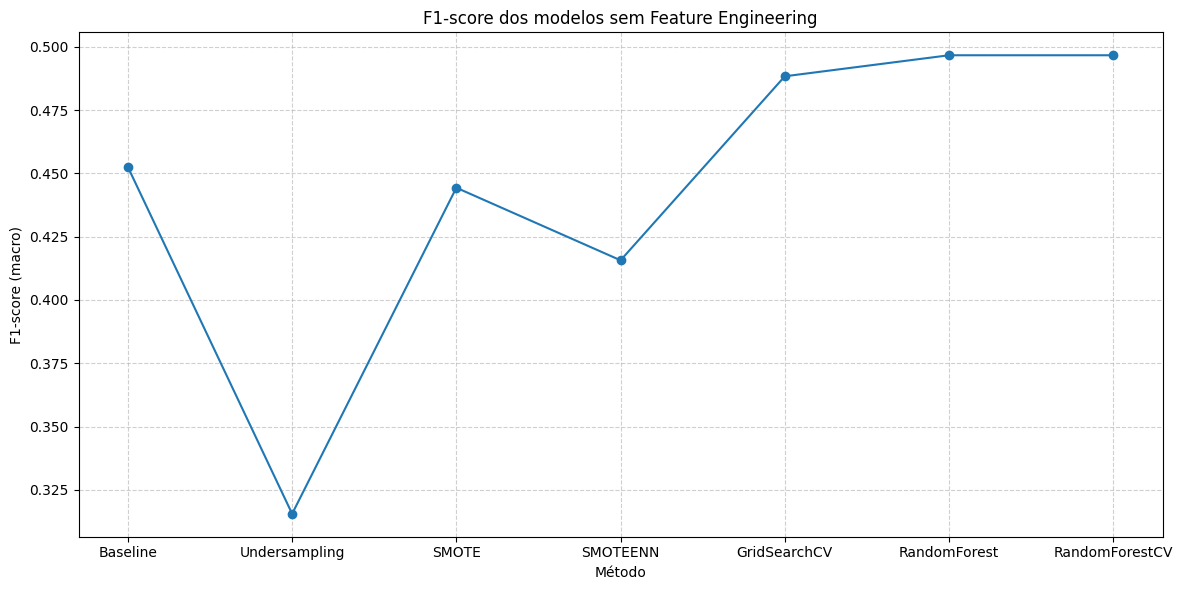

In [212]:
plt.figure(figsize=(12, 6))
plt.plot(list(f1_scores.keys()), list(f1_scores.values()), marker='o')
plt.title('F1-score dos modelos sem Feature Engineering')
plt.ylabel('F1-score (macro)')
plt.xlabel('Método')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



In [213]:
# Comparação final de F1-scores entre todas as estratégias sem Feature Engineering
print('Baseline:', f1_score(y_test_orig, y_pred_baseline, average='macro'))
print('Undersampling F1:', f1_score(y_test_orig, y_pred_under, average='macro'))
print('SMOTE F1:', f1_score(y_test_orig, y_pred, average='macro'))
print('SMOTEENN F1:', f1_score(y_test_orig, y_pred_smoteenn, average='macro'))
print('GridSearchCV F1:', f1_score(y_test_orig, y__pred, average='macro'))
print('RandomForest F1:', f1_score(y_test_orig, y_pred_rf, average='macro'))
print('RandomForestCV F1:', f1_score(y_test_orig, y____pred, average='macro'))

Baseline: 0.4524549465368879
Undersampling F1: 0.31554942914506606
SMOTE F1: 0.44430169101632283
SMOTEENN F1: 0.41564561734213007
GridSearchCV F1: 0.4883145140113291
RandomForest F1: 0.49661614885185384
RandomForestCV F1: 0.49661614885185384


Estes resultados representam o desempenho dos modelos sem aplicação de Feature Engineering , ou seja, com os dados originais:

* Linha de base : Mesmo sem ajustes, o modelo inicial já apresentou pontuação F1 razoável, refletindo que parte da estrutura do problema é capturada naturalmente. Contudo, o desbalanceamento prejudica a generalização.

* Undersampling : Teve o pior resultado, pois remover amostras da classe majoritária fez o algoritmo perder informações valiosas, caindo o F1-score para o ponto mais baixo dos gráficos.

* SMOTE : Houve melhorias significativas na métrica, pois o balanceamento via oversampling preserva a diversidade dos dados sem descartar exemplos reais. O ganho, porém, ainda é limitado pela ausência de transformações adicionais.

* SMOTEENN : Apesar de sua proposta de eliminar ruídos após o balanceamento, neste contexto o SMOTEENN teve desempenho inferior ao SMOTE . O gráfico mostra queda no placar F1, diminuindo que a limpeza com ENN provavelmente removeu exemplos relevantes ou amplificados do problema do desbalanceamento, prejudicando a capacidade de classificação.

* GridSearchCV (KNN) : O ajuste de hiperparâmetros para o KNN via Grid Search trouxe evolução, porém o modelo manteve-se sensível ao ruído e limitações de distância, mostrando que apenas a otimização do KNN não eleva muito o desempenho neste cenário.

* Random Forest : Marcou um salto claro de qualidade, explorando melhores relações não lineares e interações dos dados.

* RandomForestCV (Random Forest otimizado) : O ajuste dos hiperparâmetros via GridSearchCV, neste contexto sem Feature Engineering, não trouxe melhoria significativa em relação ao RandomForest padrão . O F1-score manteve-se praticamente estável, mostrando que o modelo já estava próximo do seu potencial máximo para os dados disponíveis. Isso sugere que o ganho real de desempenho pode depender mais de melhorias nos dados (engenharia de recursos) do ajuste fino dos parâmetros do modelo nesta etapa.

In [214]:
# automatizando a execução e comparação de vários modelos (KNN e RandomForest)
resultados = []
nomes = []

acc_pipe0 = roda_pipeline(pipe0, X_train_fe, X_test_fe, y_train_fe, y_test_fe, nome="KNN Baseline")
resultados.append(acc_pipe0)
nomes.append("KNN Baseline")

acc_pipe1 = roda_pipeline(pipe1, X_train_fe, X_test_fe, y_train_fe, y_test_fe, nome="KNN com Undersampling")
resultados.append(acc_pipe1)
nomes.append("KNN com Undersampling")

acc_pipe2 = roda_pipeline(pipe2, X_train_fe, X_test_fe, y_train_fe, y_test_fe, nome="KNN com SMOTE")
resultados.append(acc_pipe2)
nomes.append("KNN com SMOTE")

acc_pipe3 = roda_pipeline(pipe3, X_train_fe, X_test_fe, y_train_fe, y_test_fe, nome="KNN com SMOTEENN")
resultados.append(acc_pipe3)
nomes.append("KNN com SMOTEENN")

acc_pipe4 = roda_pipeline(grid_knn, X_train_fe, X_test_fe, y_train_fe, y_test_fe, nome="GRID SEARCH")
resultados.append(acc_pipe4)
nomes.append("GRID SEARCH")

acc_pipe5 = roda_pipeline(rf, X_train_fe, X_test_fe, y_train_fe, y_test_fe, nome="Random Forest")
resultados.append(acc_pipe5)
nomes.append("Random Forest")

acc_pipe6 = roda_pipeline(grid_rf, X_train_fe, X_test_fe, y_train_fe, y_test_fe, nome="Random Forest CV")
resultados.append(acc_pipe6)
nomes.append("Random Forest CV")

---------------------------------------------
Resultados - KNN Baseline
              precision    recall  f1-score   support

           0       0.26      0.04      0.08       537
           1       0.71      0.95      0.81      1323

    accuracy                           0.69      1860
   macro avg       0.48      0.50      0.44      1860
weighted avg       0.58      0.69      0.60      1860

Recall Classe 0 (Insatisfeito): 0.0447
Recall Classe 1 (Satisfeito):   0.9478
---------------------------------------------
Resultados - KNN com Undersampling
              precision    recall  f1-score   support

           0       0.29      0.97      0.45       537
           1       0.76      0.04      0.07      1323

    accuracy                           0.31      1860
   macro avg       0.53      0.50      0.26      1860
weighted avg       0.63      0.31      0.18      1860

Recall Classe 0 (Insatisfeito): 0.9702
Recall Classe 1 (Satisfeito):   0.0393
-------------------------------------

plt.plot(nomes,resultados, color='red', marker='o', label='Classe 0 - Insatisfeito')

Após a aplicação de técnicas de Feature Engineering , foi possível observar, que diversos modelos tiveram uma melhoria discreta no F1-score — independentemente do algoritmo ou das estratégias de balanceamento e otimização utilizadas. No entanto, vale ressaltar que esse progresso não se refletiu no modelo KNN com Undersampling : apesar das aparentes elevações globais, o modelo ficou altamente invejado, priorizando quase exclusivamente uma das classes da variável alvo.

Em outras palavras, o Undersampling comprometeu a capacidade de equilíbrio do KNN na distinção entre as classes, fazendo com que previsse essencialmente apenas um dos lados do alvo. Com isso, análises isoladas escondem o verdadeiro desempenho prático e as limitações do modelo diante do problema real de satisfação do cliente.

Esse resultado evidencia que a qualidade dos dados é fundamental para o sucesso em projetos de Machine Learning . O ponto-chave não é apenas na escolha do modelo ou na busca pelo melhor ajuste, mas sim no investimento em dados bem trabalhados e informativos. Dados de qualidade são o maior diferencial competitivo para alcançar modelos de alto desempenho, consistência e relevância nos resultados.

O modelo Random Forest CV foi o mais eficaz dentre as abordagens testadas, atingindo um F1-Macro de 0,50 e conseguindo identificar 57% dos clientes insatisfeitos. Contudo, a análise de brilho e os resultados dos modelos revelam que as variáveis ​​disponíveis (Qualidade da Comida, Tempo e Experiência de Entrega) não são suficientes para prever com alta precisão se um pedido será entregue corretamente. O baixo desempenho não significa necessariamente uma falha do modelo, mas sim uma limitação dos dados de entrada.

Vamos Salvar nosso modelo

In [215]:
joblib.dump(grid_rf.best_estimator_, 'melhor_modelo_rf_cv.sav')

['melhor_modelo_rf_cv.sav']

Este projeto foi construído com foco em um aprendizado realista e experimental. Mais importante do que a busca por métricas máximas, destacou-se o processo de avaliação dos dados e modelos, evidenciando a importância da compreensão dos limites das informações disponíveis — o que é essencial em aplicações reais de Machine Learning.